Cross section requires the incident kinetic energy $KE_{inc}$ and the interacting kinetic energy $KE_{int}$.

$KE_{inst}$ is the kinetic energy from the beam instrumentation and $KE_{init}$ is the kinetic energy at the front face of the TPC when the particle first enters LAr.

$$
KE_{init} = KE_{inst} - \Delta E_{loss}
$$

$\Delta E_{loss}$ is the the energy lost by by the beam particle from the instrumentation to the front face, this needs to be estimating in simulation, then applied to data.

$$
KE_{int} = KE_{init} - \Delta E_{deposit}
$$

$\Delta E_{deposit}$ can be found in two ways:

 - find $\frac{dE}{dx}$ using the bethe bloch formula from $KE_{init}$ and then $\int\frac{dE}{dx} dx$
 - use the SCE corrected estimate of the energy deposited at a trejctory point from the calorimetry object, $\sum\Delta E_{calo}$



In [1]:
# This is boilerplate code to correctly setup the settings to for notebook.
import os, sys
for root, dirs, files in os.walk(os.getcwd()):
    # print(root)

    if "pi0-analysis" in root.split("/"):
        pypath = root.split("pi0-analysis")[0] + "/pi0-analysis/analysis"
        print(pypath)
        break

sys.path.insert(0, pypath)

from python.analysis.NotebookUtils import init_notebook
%init_notebook

/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis
/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis
env: PYTHONPATH=/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis


In [2]:
from python.analysis import cross_section, Fitting
from python.analysis import Master, Plots, BeamParticleSelection
from apps.cex_analysis_input import BeamPionSelection

import awkward as ak
import copy
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

from particle import Particle

from rich import print

# plt.style.use("cyberpunk")
# plt.rcParams["figure.dpi"] = 140
cross_section.PlotStyler.SetPlotStyle(extend_colors = True, dpi = 140)

def hist_glow(alpha = 0.03, n = 5, width = 1.05):
    ax = plt.gca()
    for patch in ax.get_children()[:-1]: # last patch in children is the grid
        if type(patch) not in [matplotlib.patches.Polygon, matplotlib.patches.Rectangle]: continue # only add glow to histogram patches
        for i in range(1, n + 1):
            new_patch = copy.copy(patch)

            if new_patch.get_edgecolor() == (0, 0, 0, 0):
                edgecolor = new_patch.get_facecolor()
            else:
                edgecolor = new_patch.get_edgecolor()

            new_patch.set(alpha = alpha, linewidth = new_patch.get_linewidth() + (width * i), edgecolor = edgecolor, facecolor = new_patch.get_facecolor(), zorder = 0.6) # grid lines are hardcoded at zorder 0.5
            ax.add_patch(new_patch)


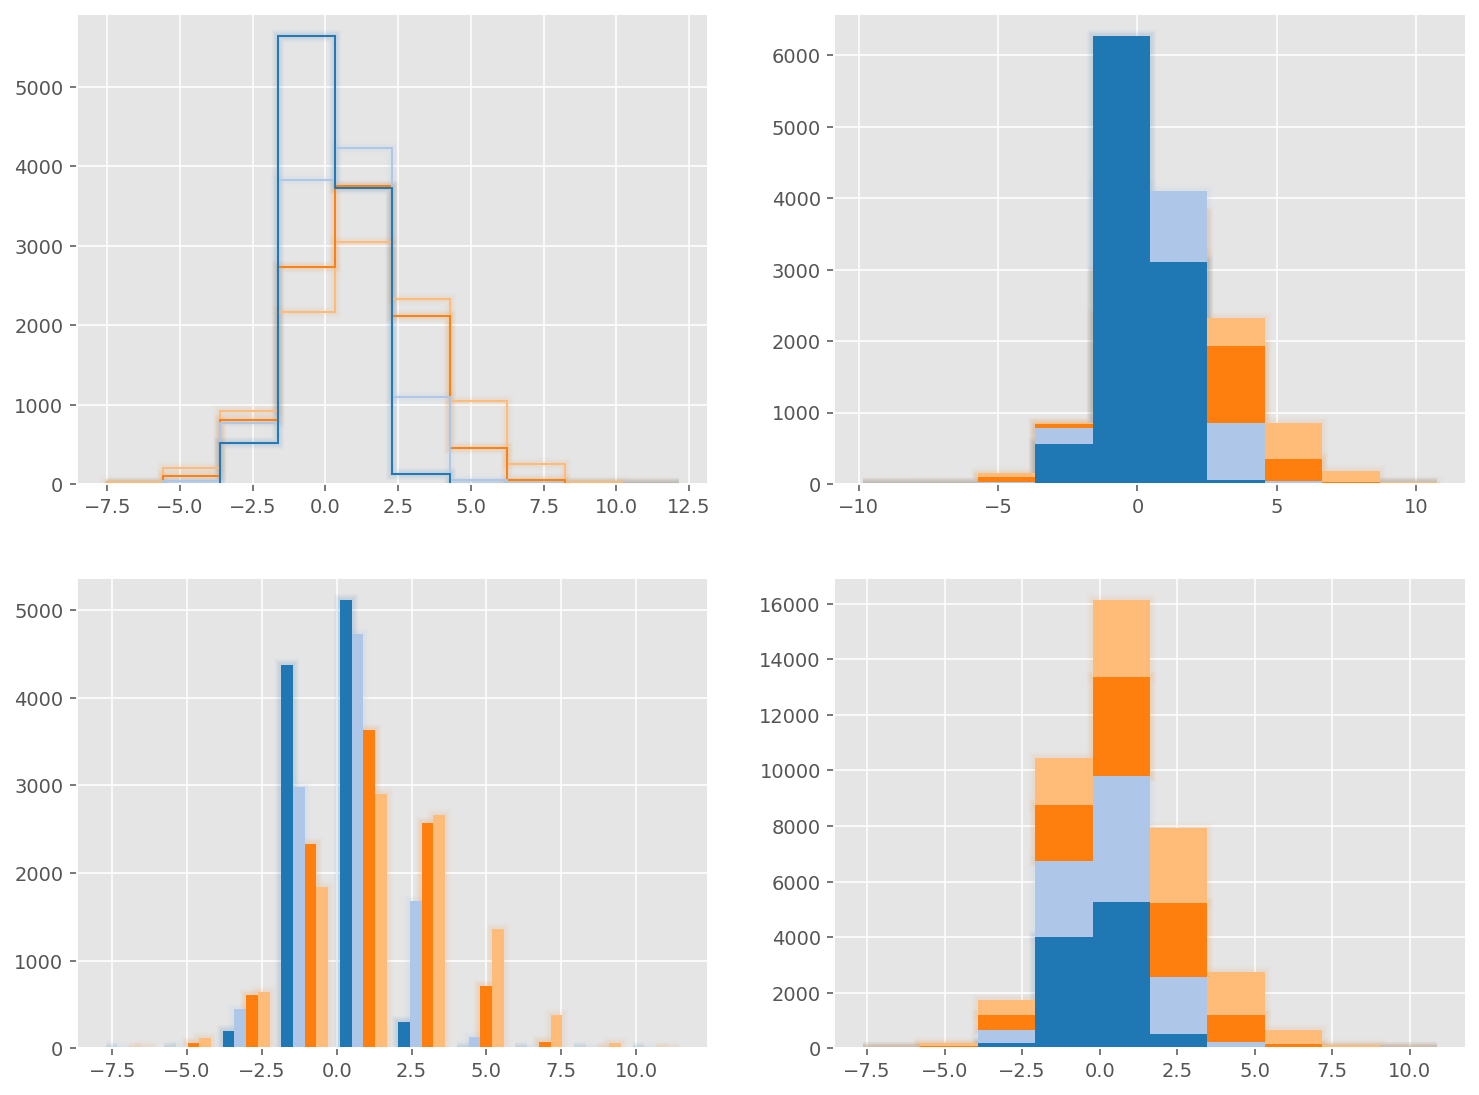

In [4]:
plt.subplots(2, 2, figsize = (6.4 * 2, 4.8 * 2))

mode = ["step", "stepfilled", "bar", "barstacked"]
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(np.random.normal((0, 0.5, 1, 1.5), (1, 1.5, 2, 2.5), (10000, 4)), stacked = False, histtype = mode[i])
    hist_glow(n = 5)


# Event Selection

In [3]:
config = "/home/bhuller/new_python_test/xs_analysis/work/anlysis_main/cex_analysis_2GeV_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))

ntuple = args.ntuple_files["mc"][0]

mc = Master.Data(ntuple["file"], nTuple_type = ntuple["type"], target_momentum = ntuple["pmom"], nEvents = -1)
# data = Master.Data(args.data_file, nTuple_type = Master.Ntuple_Type.PDSP)
mc = BeamPionSelection(mc, args, True)
# mask = mc.trueParticles.pdg[:, 0] == 211 #! for this study only, select true pions

f=<Array [True, False, True, True, ..., False, True, False] type='131266 * bool'>
f=<Array [False, False, True, True, ..., False, True, False] type='52654 * ?bool'>
f=<Array [[True, True, ..., True, True], ...] type='21372 * option[var * bool]'>


'BeamPionSelection' executed in 0.0286s

In [5]:
mc.io.ListNTuples("range")

[
    'reco_beam_resRange_SCE',
    'reco_beam_resRange_NoSCE',
    'reco_daughter_allTrack_resRange_SCE',
    'reco_daughter_allTrack_resRange_plane0',
    'reco_daughter_allTrack_resRange_plane1',
    'reco_daughter_allTrack_momByRange_proton',
    'reco_daughter_allTrack_momByRange_muon',
    'reco_beam_momByRange_proton',
    'reco_beam_momByRange_muon',
    'reco_daughter_allTrack_momByRange_alt_proton',
    'reco_daughter_allTrack_momByRange_alt_muon',
    'reco_beam_momByRange_alt_proton',
    'reco_beam_momByRange_alt_muon'
]

In [10]:
res_range = mc.io.Get("reco_beam_resRange_SCE")
res_range

<Array [[61.6, 61, 60.4, ..., 0.57, 0.19], ...] type='131266 * var * float64'>

In [9]:
mc.recoParticles.beam_calo_pos

<Array [[{x: -29.2, y: 422, ...}, ...], ...] type='21372 * option[var * {x:...'>

In [6]:
pdf = Plots.PlotBook("beam_KE_plots.pdf", open = False)

In [7]:
class labels: # plot labels
    KE_reco_inst = "$KE^{reco}_{inst}$"
    KE_reco_ff = "$KE^{reco}_{init}$"
    KE_reco_int = "$KE^{reco}_{int}$"
    KE_reco_int_bb = "$KE^{reco}_{int, bb}$"
    KE_reco_int_calo = "$KE^{reco}_{int, calo}$"
    Delta_E_reco = "$\\Delta E^{reco}$"
    Delta_E_reco_bb = "$\\Delta E^{reco}_{bb}$"
    Delta_E_reco_calo = "$\\Delta E^{reco}_{calo}$"
    KE_true_ff = "$KE^{true}_{init}$"
    KE_true_int = "$KE^{true}_{int}$"
    Delta_E_true = "$\\Delta E^{true}$"
    mu_KE_reco_inst_minus_KE_true_ff = "$\\mu($" + KE_reco_inst + "$-$" + KE_true_ff + "$)$"
    MeV = "(MeV)"

KE_range = [1000, 3000]

# $KE^{true}_{init}$ and $KE^{reco}_{inst}$

In [8]:
KE_reco_inst = cross_section.KE(mc.recoParticles.beam_inst_P, Particle.from_pdgid(211).mass)
KE_true_ff = mc.trueParticles.beam_KE_front_face

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 100)),
 [array([1000., 1020., 1040., 1060., 1080., 1100., 1120., 1140., 1160.,
         1180., 1200., 1220., 1240., 1260., 1280., 1300., 1320., 1340.,
         1360., 1380., 1400., 1420., 1440., 1460., 1480., 1500., 1520.,
         1540., 1560., 1580., 1600., 1620., 1640., 1660., 1680., 1700.,
         1720., 1740., 1760., 1780., 1800., 1820., 1840., 1860., 1880.,
         1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040., 2060.,
         2080., 2100., 2120., 2140., 2160., 2180., 2200., 2220., 2240.,
         2260., 2280., 2300., 2320., 2340., 2360., 2380., 2400., 2420.,
         2440., 2460., 2480., 2500., 2520., 2540., 2560., 2580., 2600.,
         2620., 2640., 2660., 2680., 2700., 2720., 2740., 2760., 2780.,
         2800

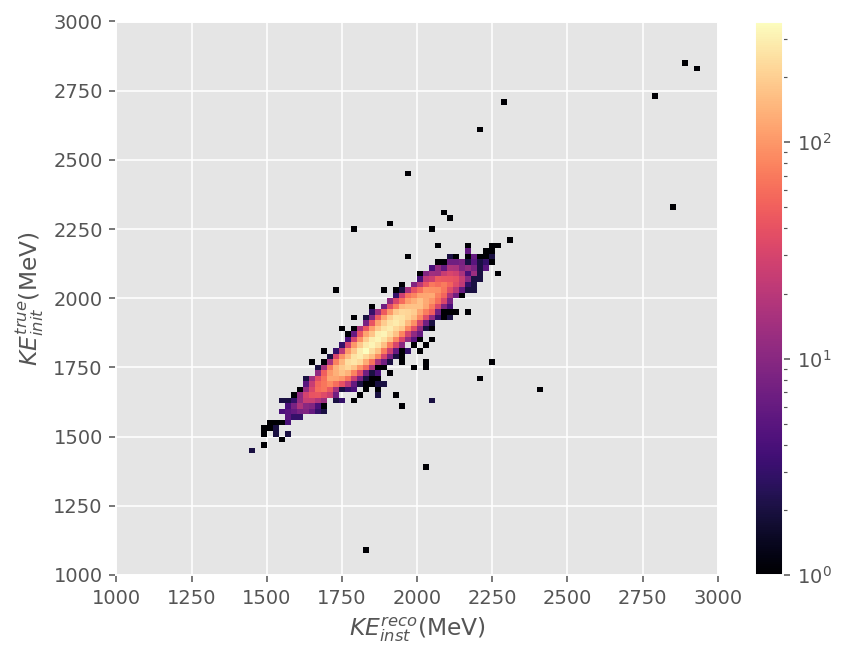

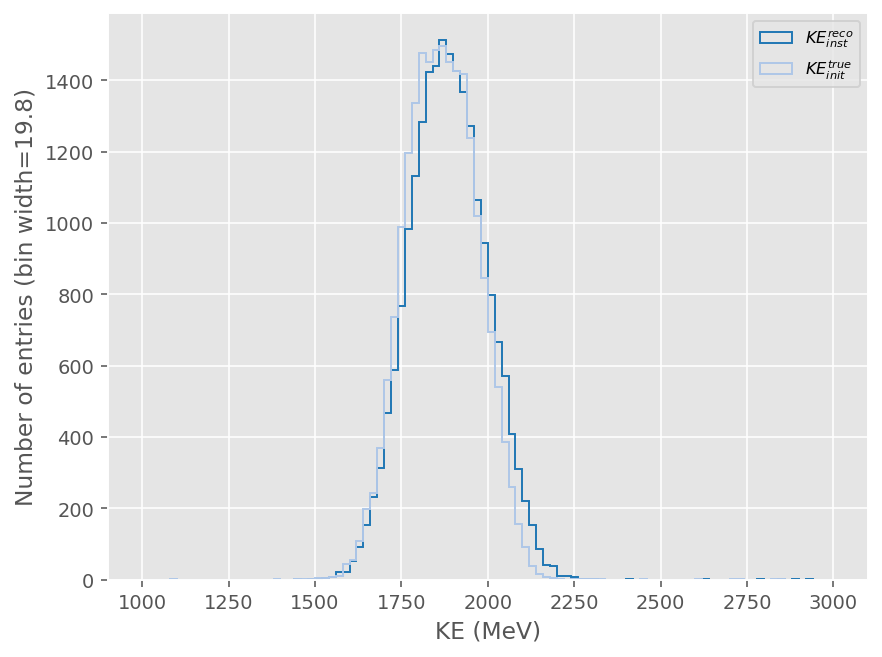

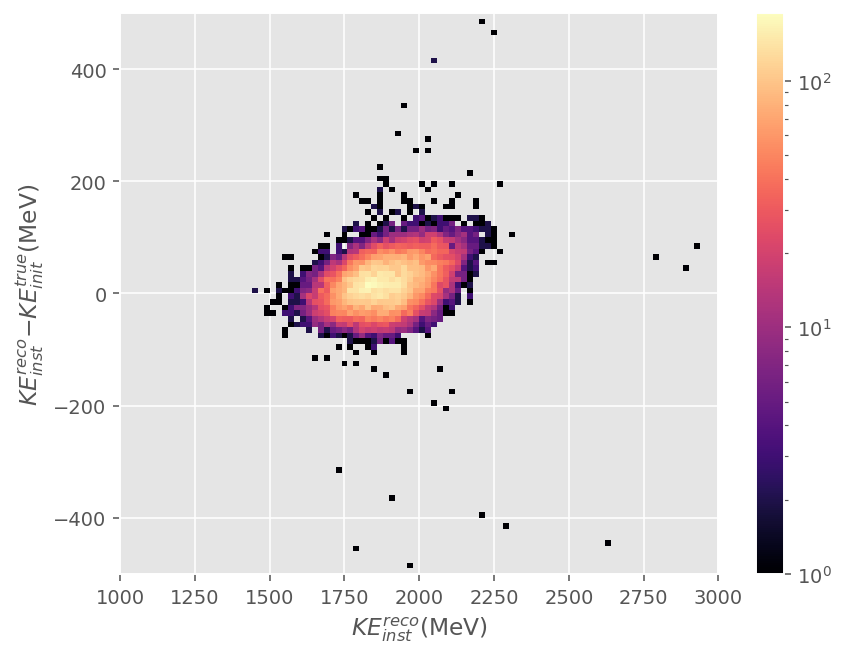

In [9]:
Plots.PlotHist2D(KE_reco_inst[KE_true_ff > 0], KE_true_ff[KE_true_ff > 0], cmap = "magma", xlabel = labels.KE_reco_inst + labels.MeV, ylabel = labels.KE_true_ff + labels.MeV, x_range = KE_range, y_range = KE_range)
pdf.Save()

Plots.PlotHistComparison([KE_reco_inst, KE_true_ff], labels = [labels.KE_reco_inst, labels.KE_true_ff], xlabel = "KE " + labels.MeV, density = False, x_range = KE_range)
pdf.Save()

Plots.PlotHist2D(KE_reco_inst[KE_true_ff > 0], (KE_reco_inst - KE_true_ff)[KE_true_ff > 0], cmap = "magma", xlabel = labels.KE_reco_inst + labels.MeV, ylabel = labels.KE_reco_inst  + "$-$" + labels.KE_true_ff + labels.MeV, x_range = KE_range, y_range = [-500, 500])


# Upstream Energy loss ($\Delta E_{loss}$)

In [10]:
def NumericalCV(bins : np.array, KE_reco_inst : np.array, KE_true_ff : np.array) -> tuple[np.array, np.array]:
    """ central value in reco bin using the arithmetic mean.

    Args:
        bins (np.array): bin edges
        KE_reco_inst (np.array): reco KE at instrumentation
        KE_true_ff (np.array): true front facing KE

    Returns:
        tuple[np.array, np.array]: arithmetc mean in each bin, error in the mean
    """
    binned_data = {"KE_inst": [], "KEff_true" : [], "KE_first_true" : []}
    for i in range(len(bins)-1):
        mask = (KE_reco_inst > bins[i]) & (KE_reco_inst < bins[i + 1])
        mask = mask & (KE_true_ff > 0)

        binned_data["KE_inst"].append( KE_reco_inst[mask] )
        binned_data["KEff_true"].append( KE_true_ff[mask] )
    binned_data = {i : ak.Array(binned_data[i]) for i in binned_data}

    print(ak.num(binned_data["KE_inst"]))
    residual_energy = binned_data["KE_inst"] - binned_data["KEff_true"]

    mean_residual_energy = ak.mean(residual_energy, axis = -1)
    mean_error_residual_energy = ak.std(residual_energy, axis = -1) / np.sqrt(ak.num(residual_energy))
    return mean_residual_energy, mean_error_residual_energy

### Fit using arithmetic mean as central value in each bin

In [11]:
# bins = ak.Array([700, 750, 800, 850, 900, 950, 1000, 1050, 1100])
bins = np.array(args.upstream_loss_bins)

mean_cv = NumericalCV(bins, KE_reco_inst, KE_true_ff)

central_values = {}
central_values["arithmetic_mean"] = {"value" : mean_cv[0], "error" : mean_cv[1]}

[898, 3936, 3424, 3709, 3421, 2653, 1789, 961, 539, 31]

### Fit using central value determined by fits 

KE_inst    true_ffKE   residual
0      1795.200733  1800.249897  -5.049164
1      1767.169079  1748.658435  18.510644
2      1861.809790  1877.898537 -16.088747
3      2018.593376  2043.685894 -25.092519
4      1701.719962  1692.560334   9.159628
...            ...          ...        ...
21367  1829.823241  1878.424710 -48.601469
21368  1860.057464  1866.944093  -6.886629
21369  1910.701108  1896.245400  14.455708
21370  2054.811553  1968.408699  86.402854
21371  1994.093540  1956.044344  38.049196

[21372 rows x 3 columns]

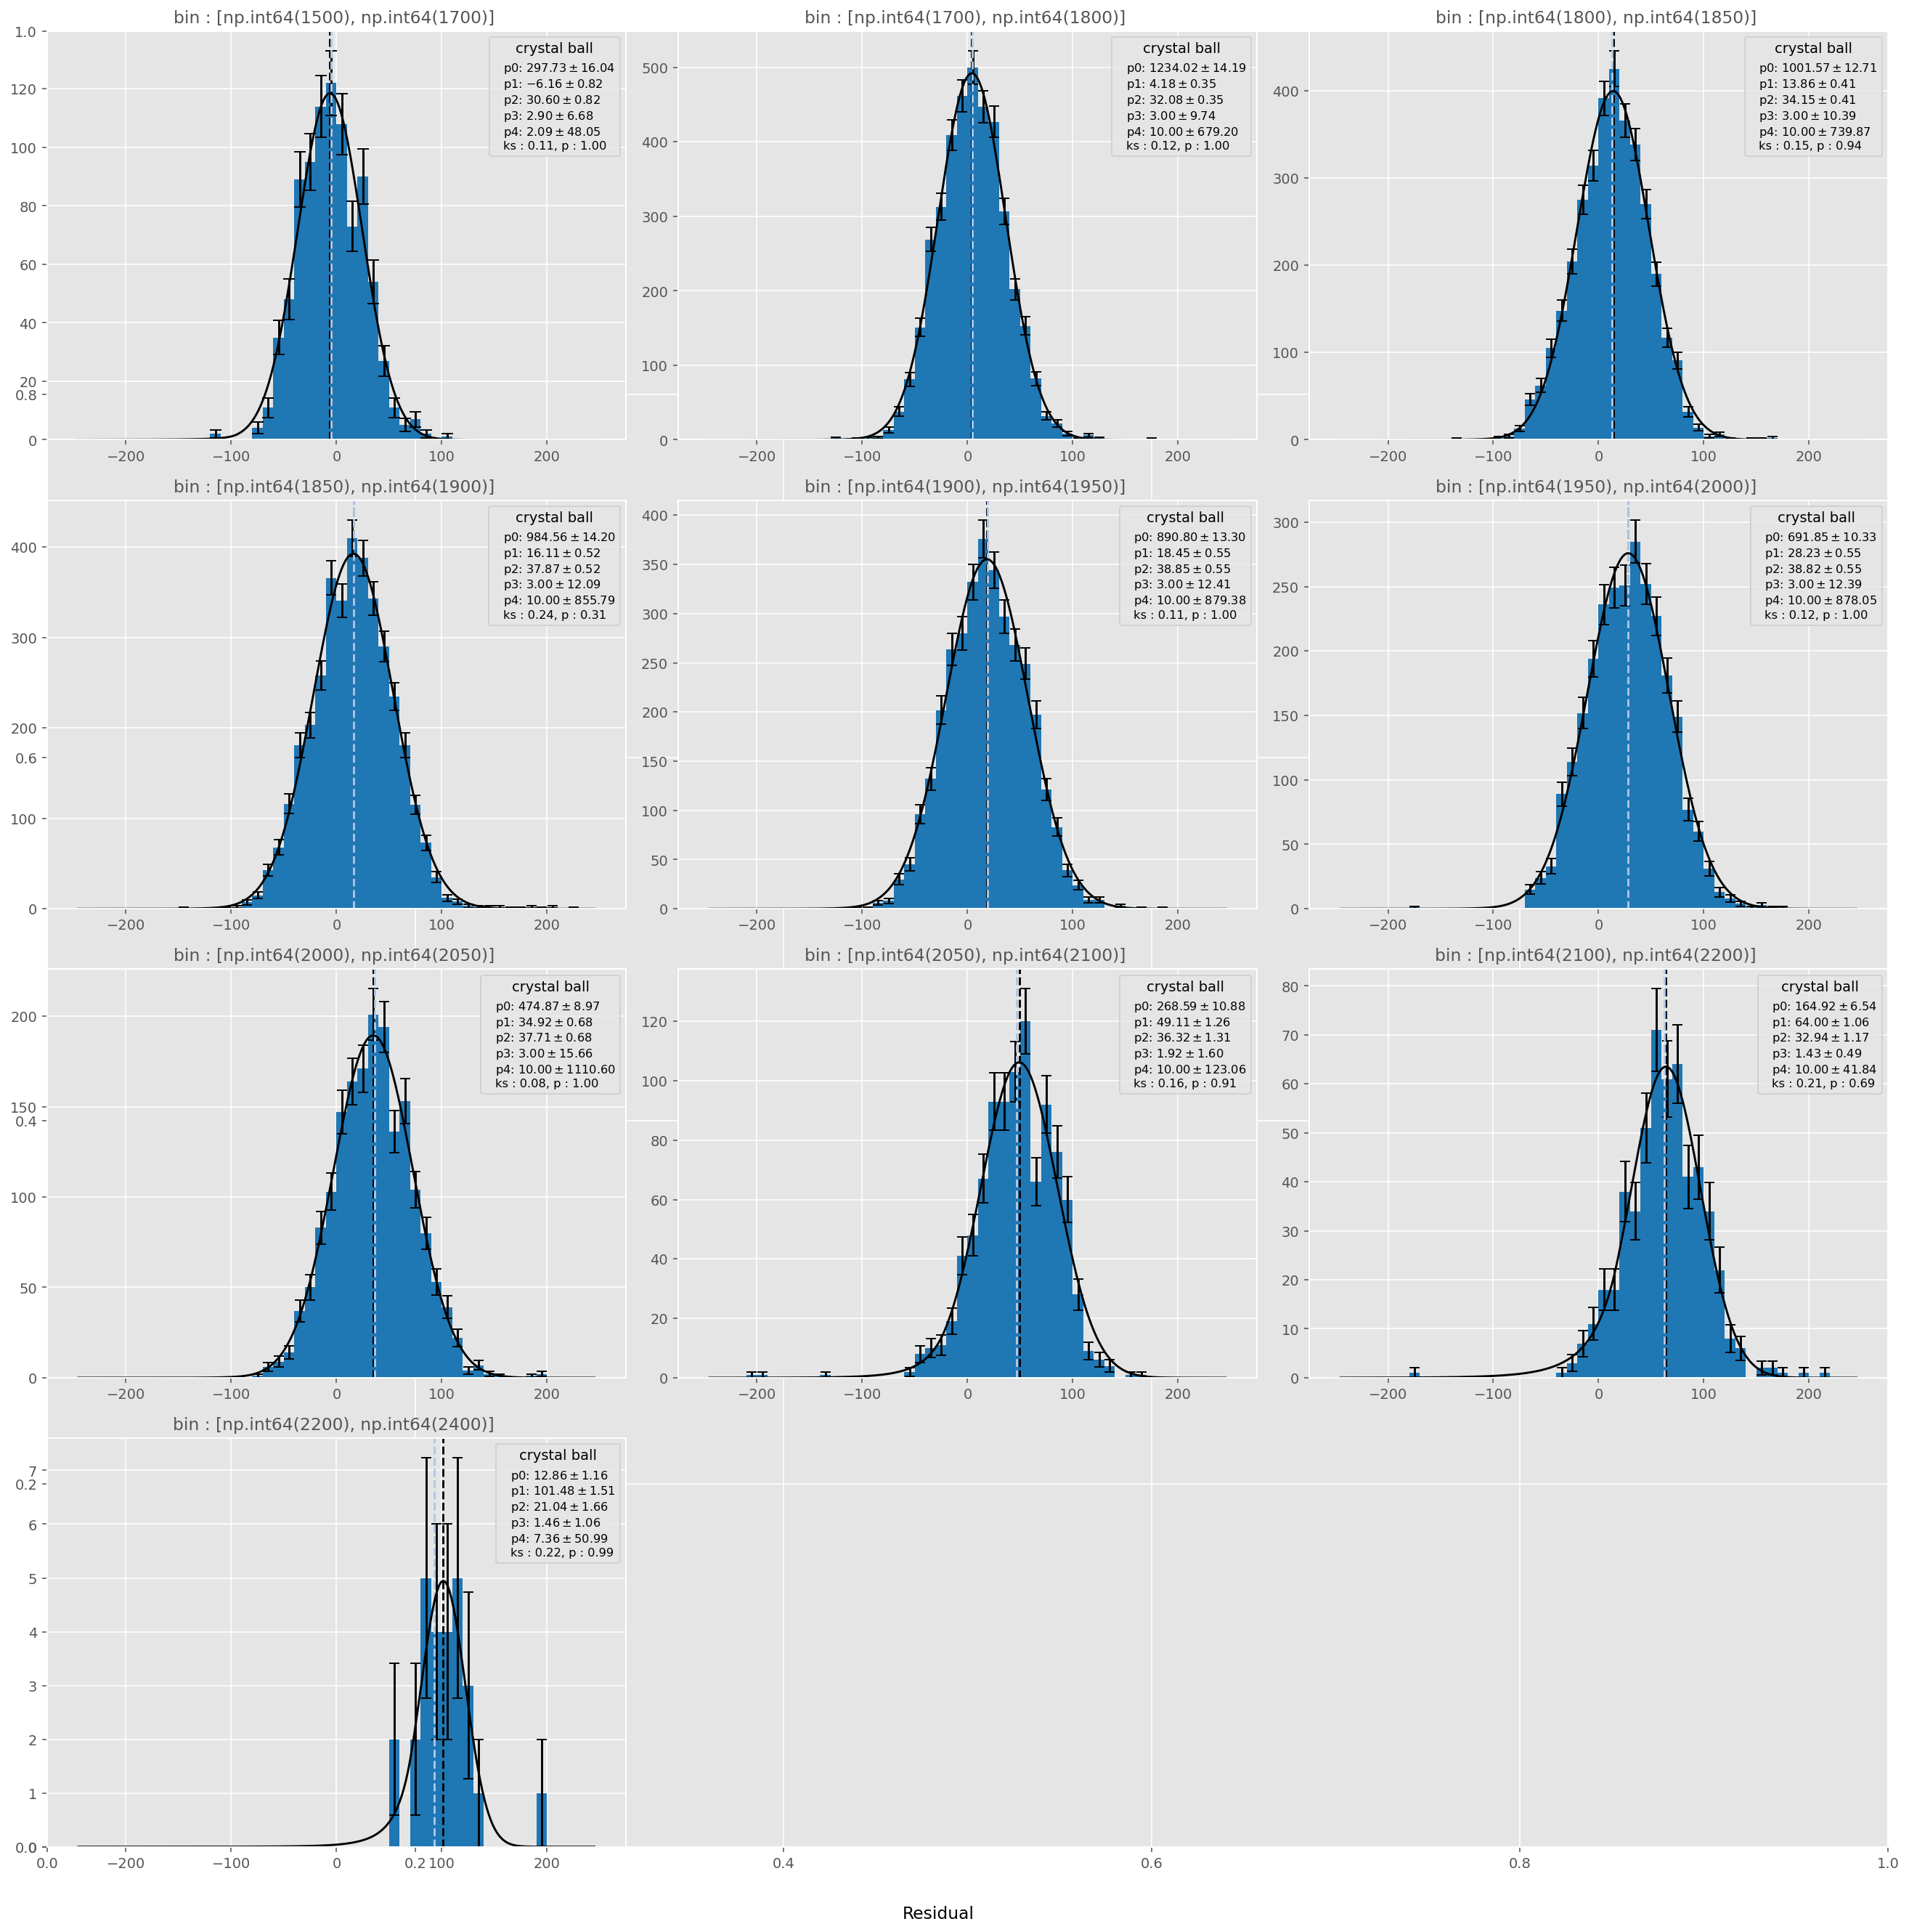

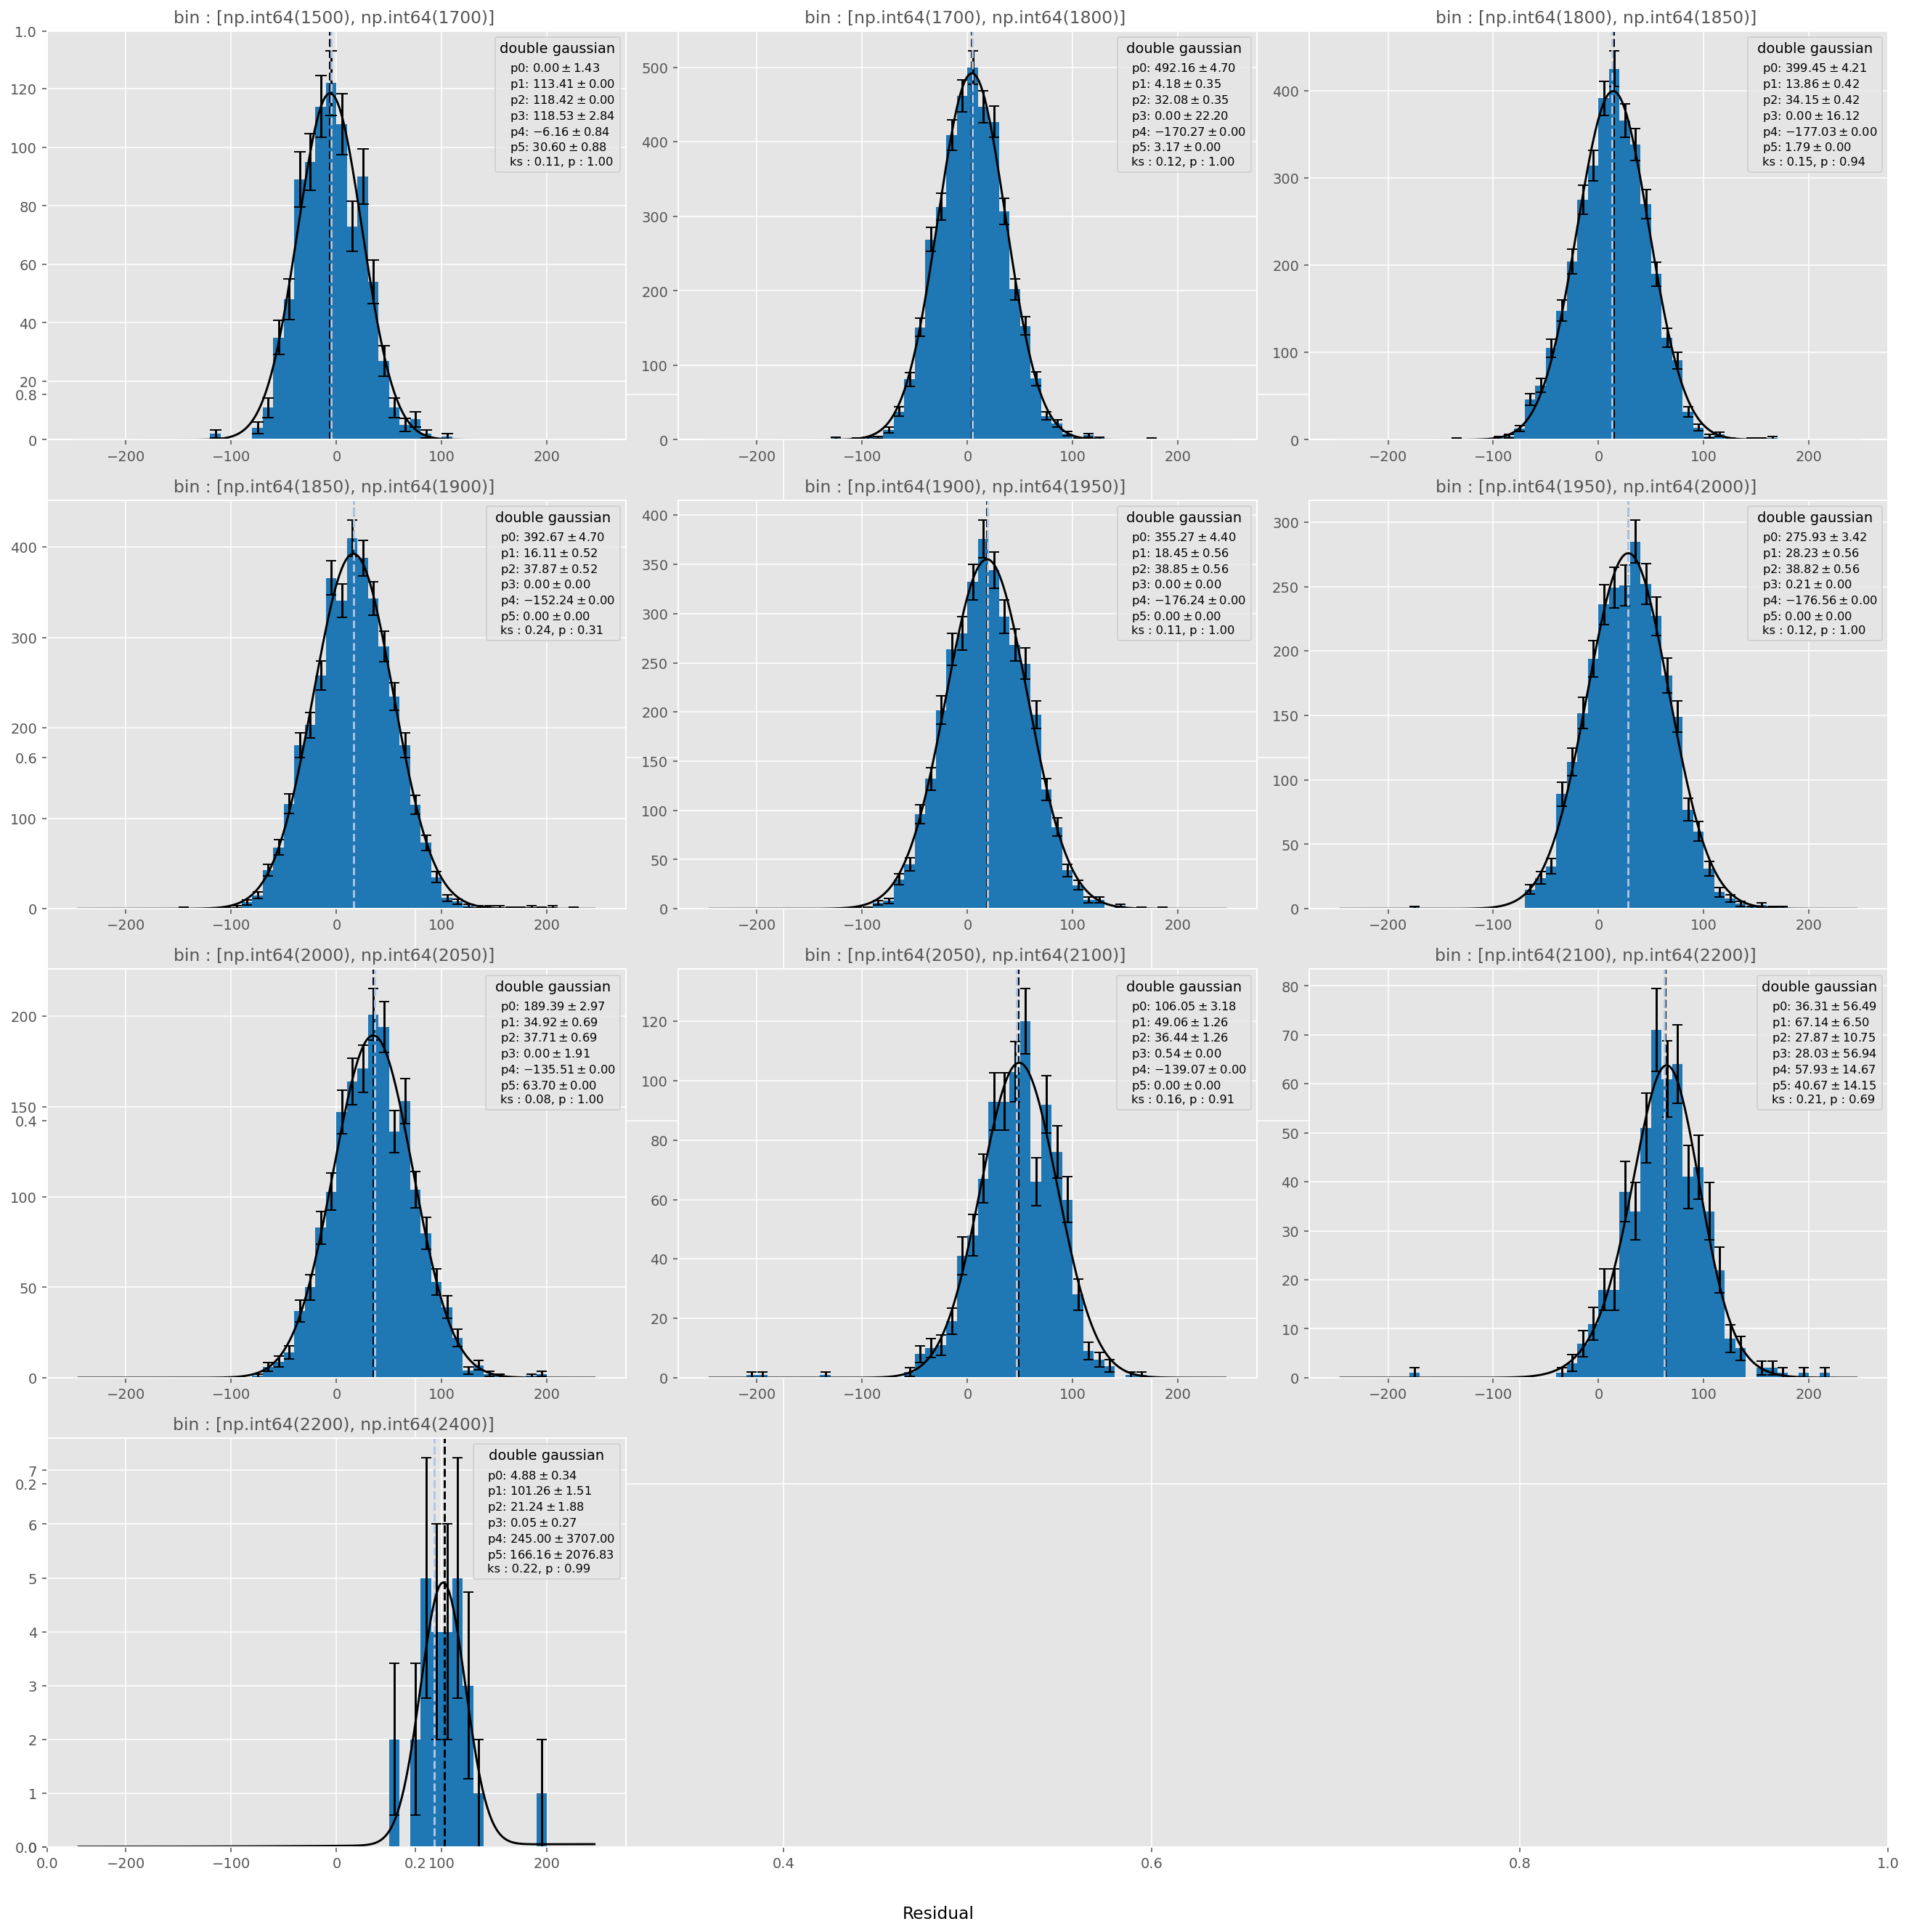

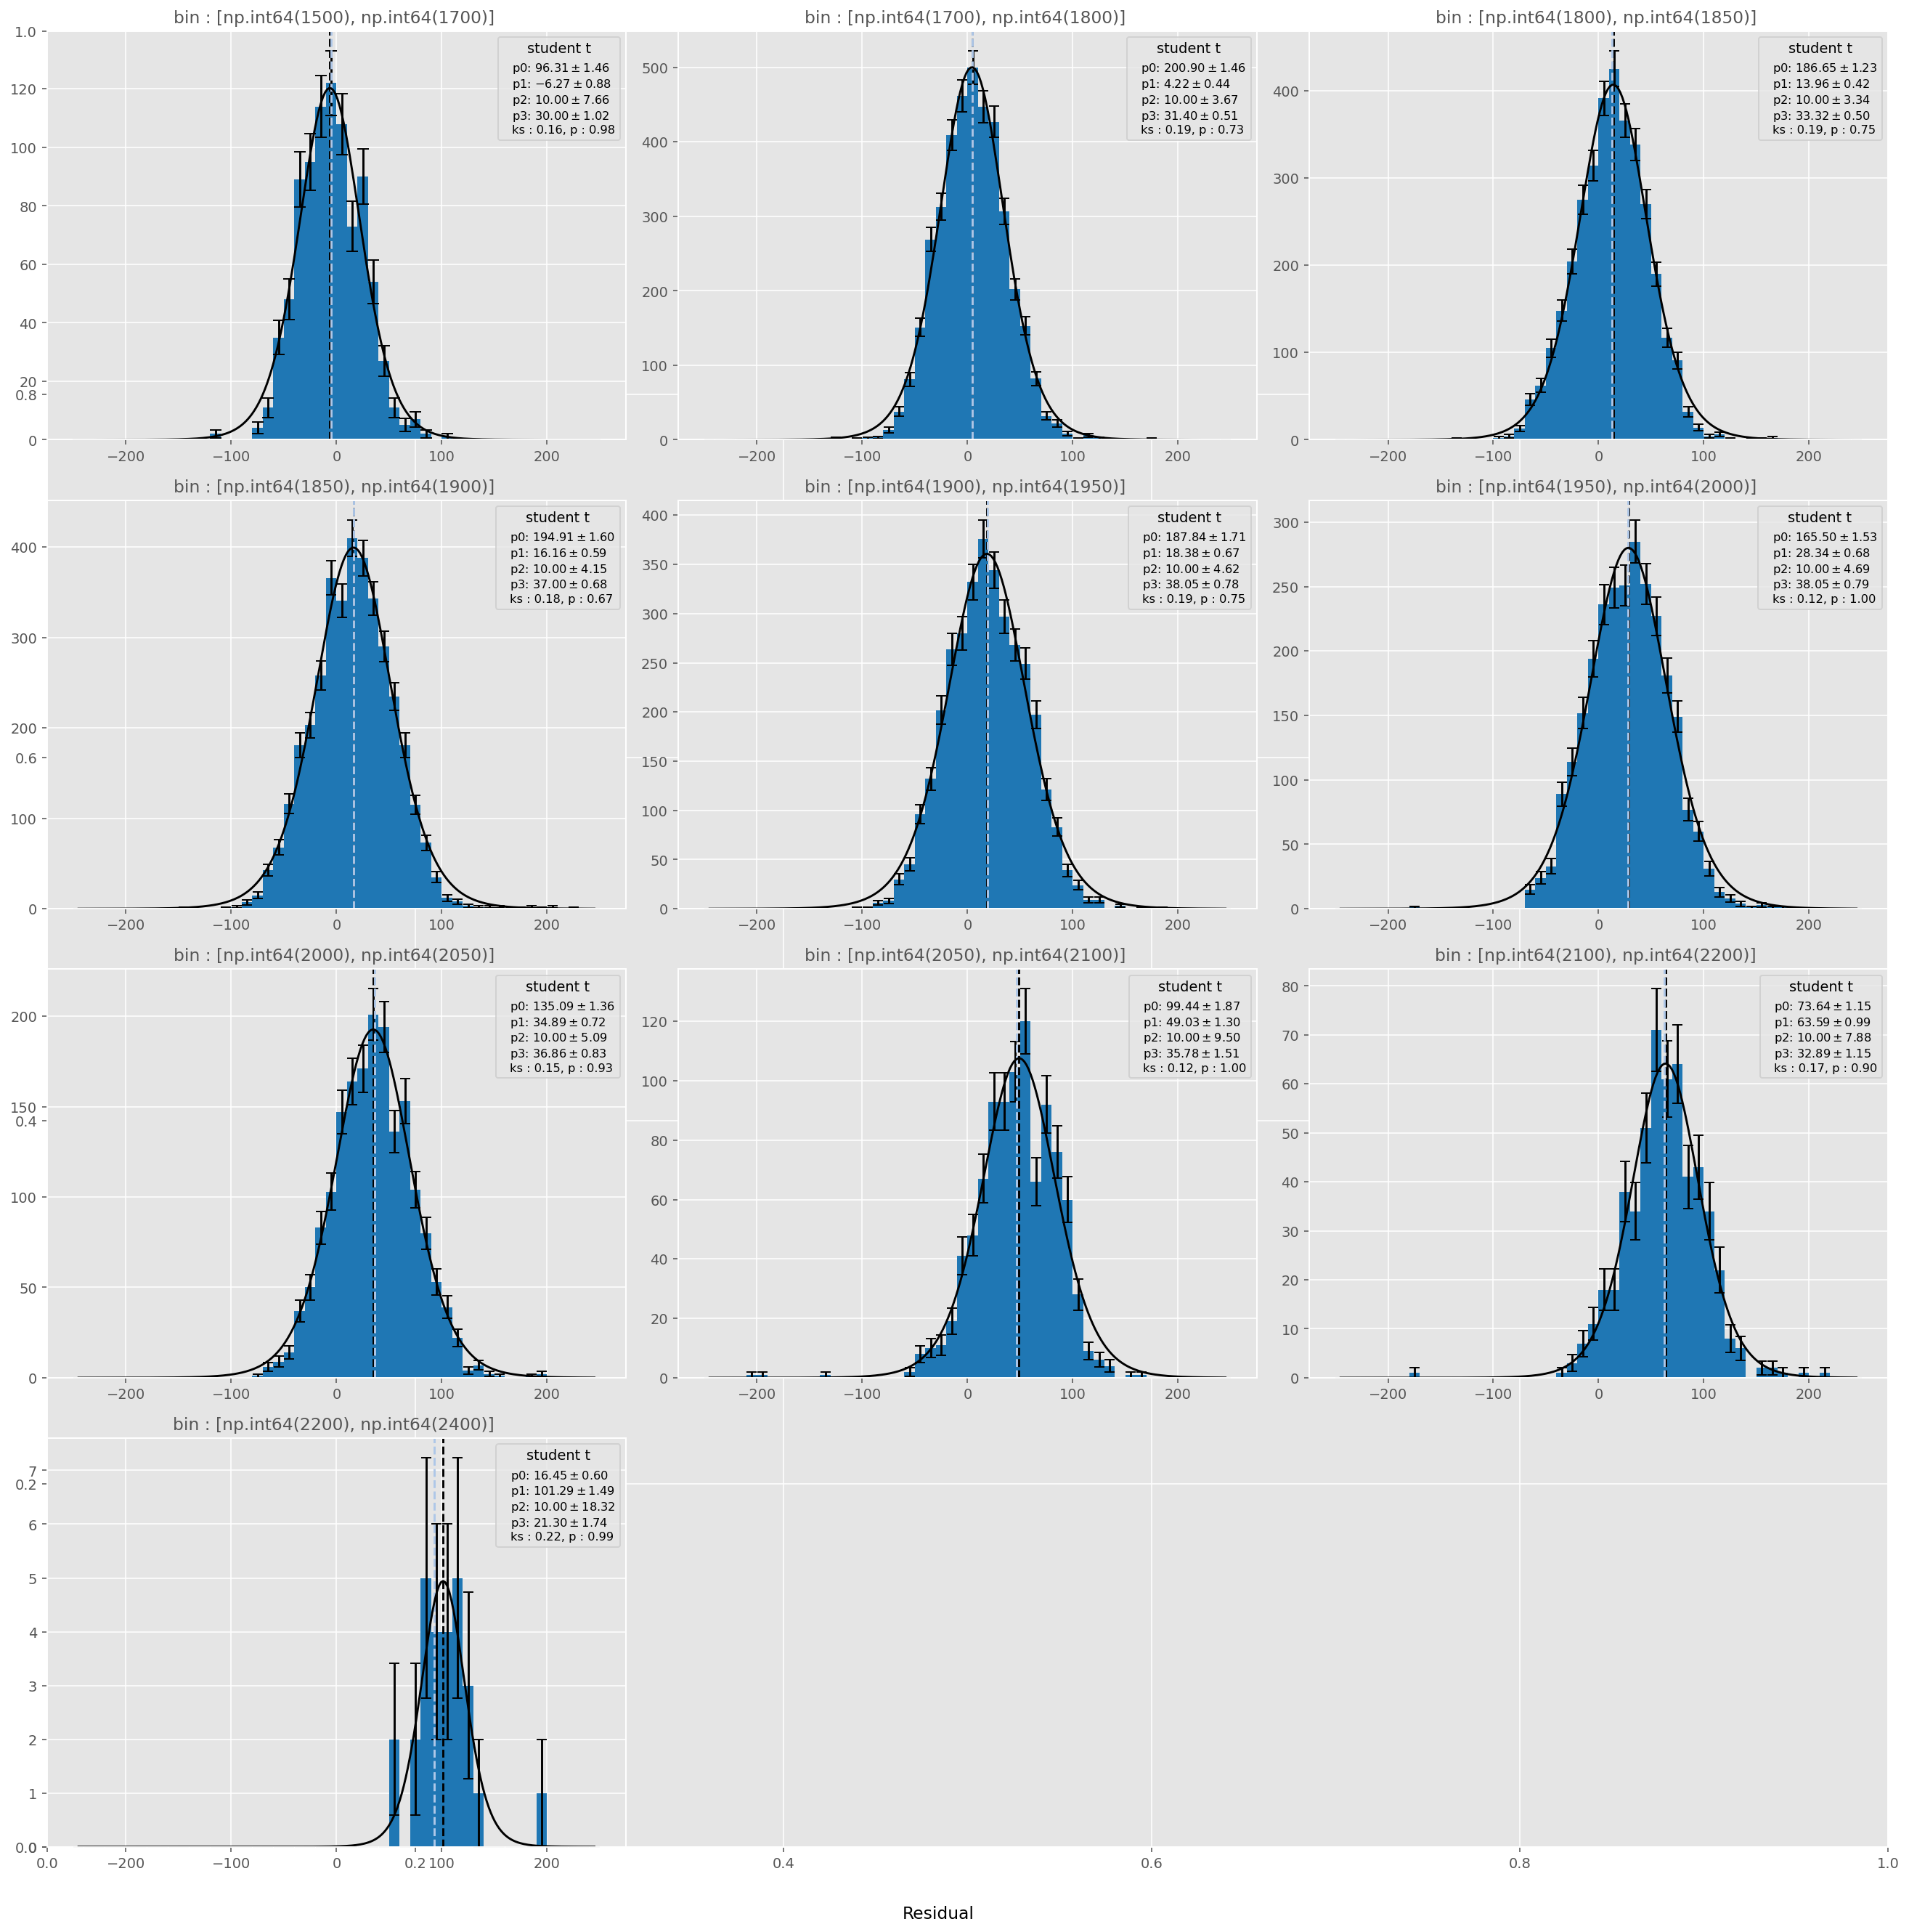

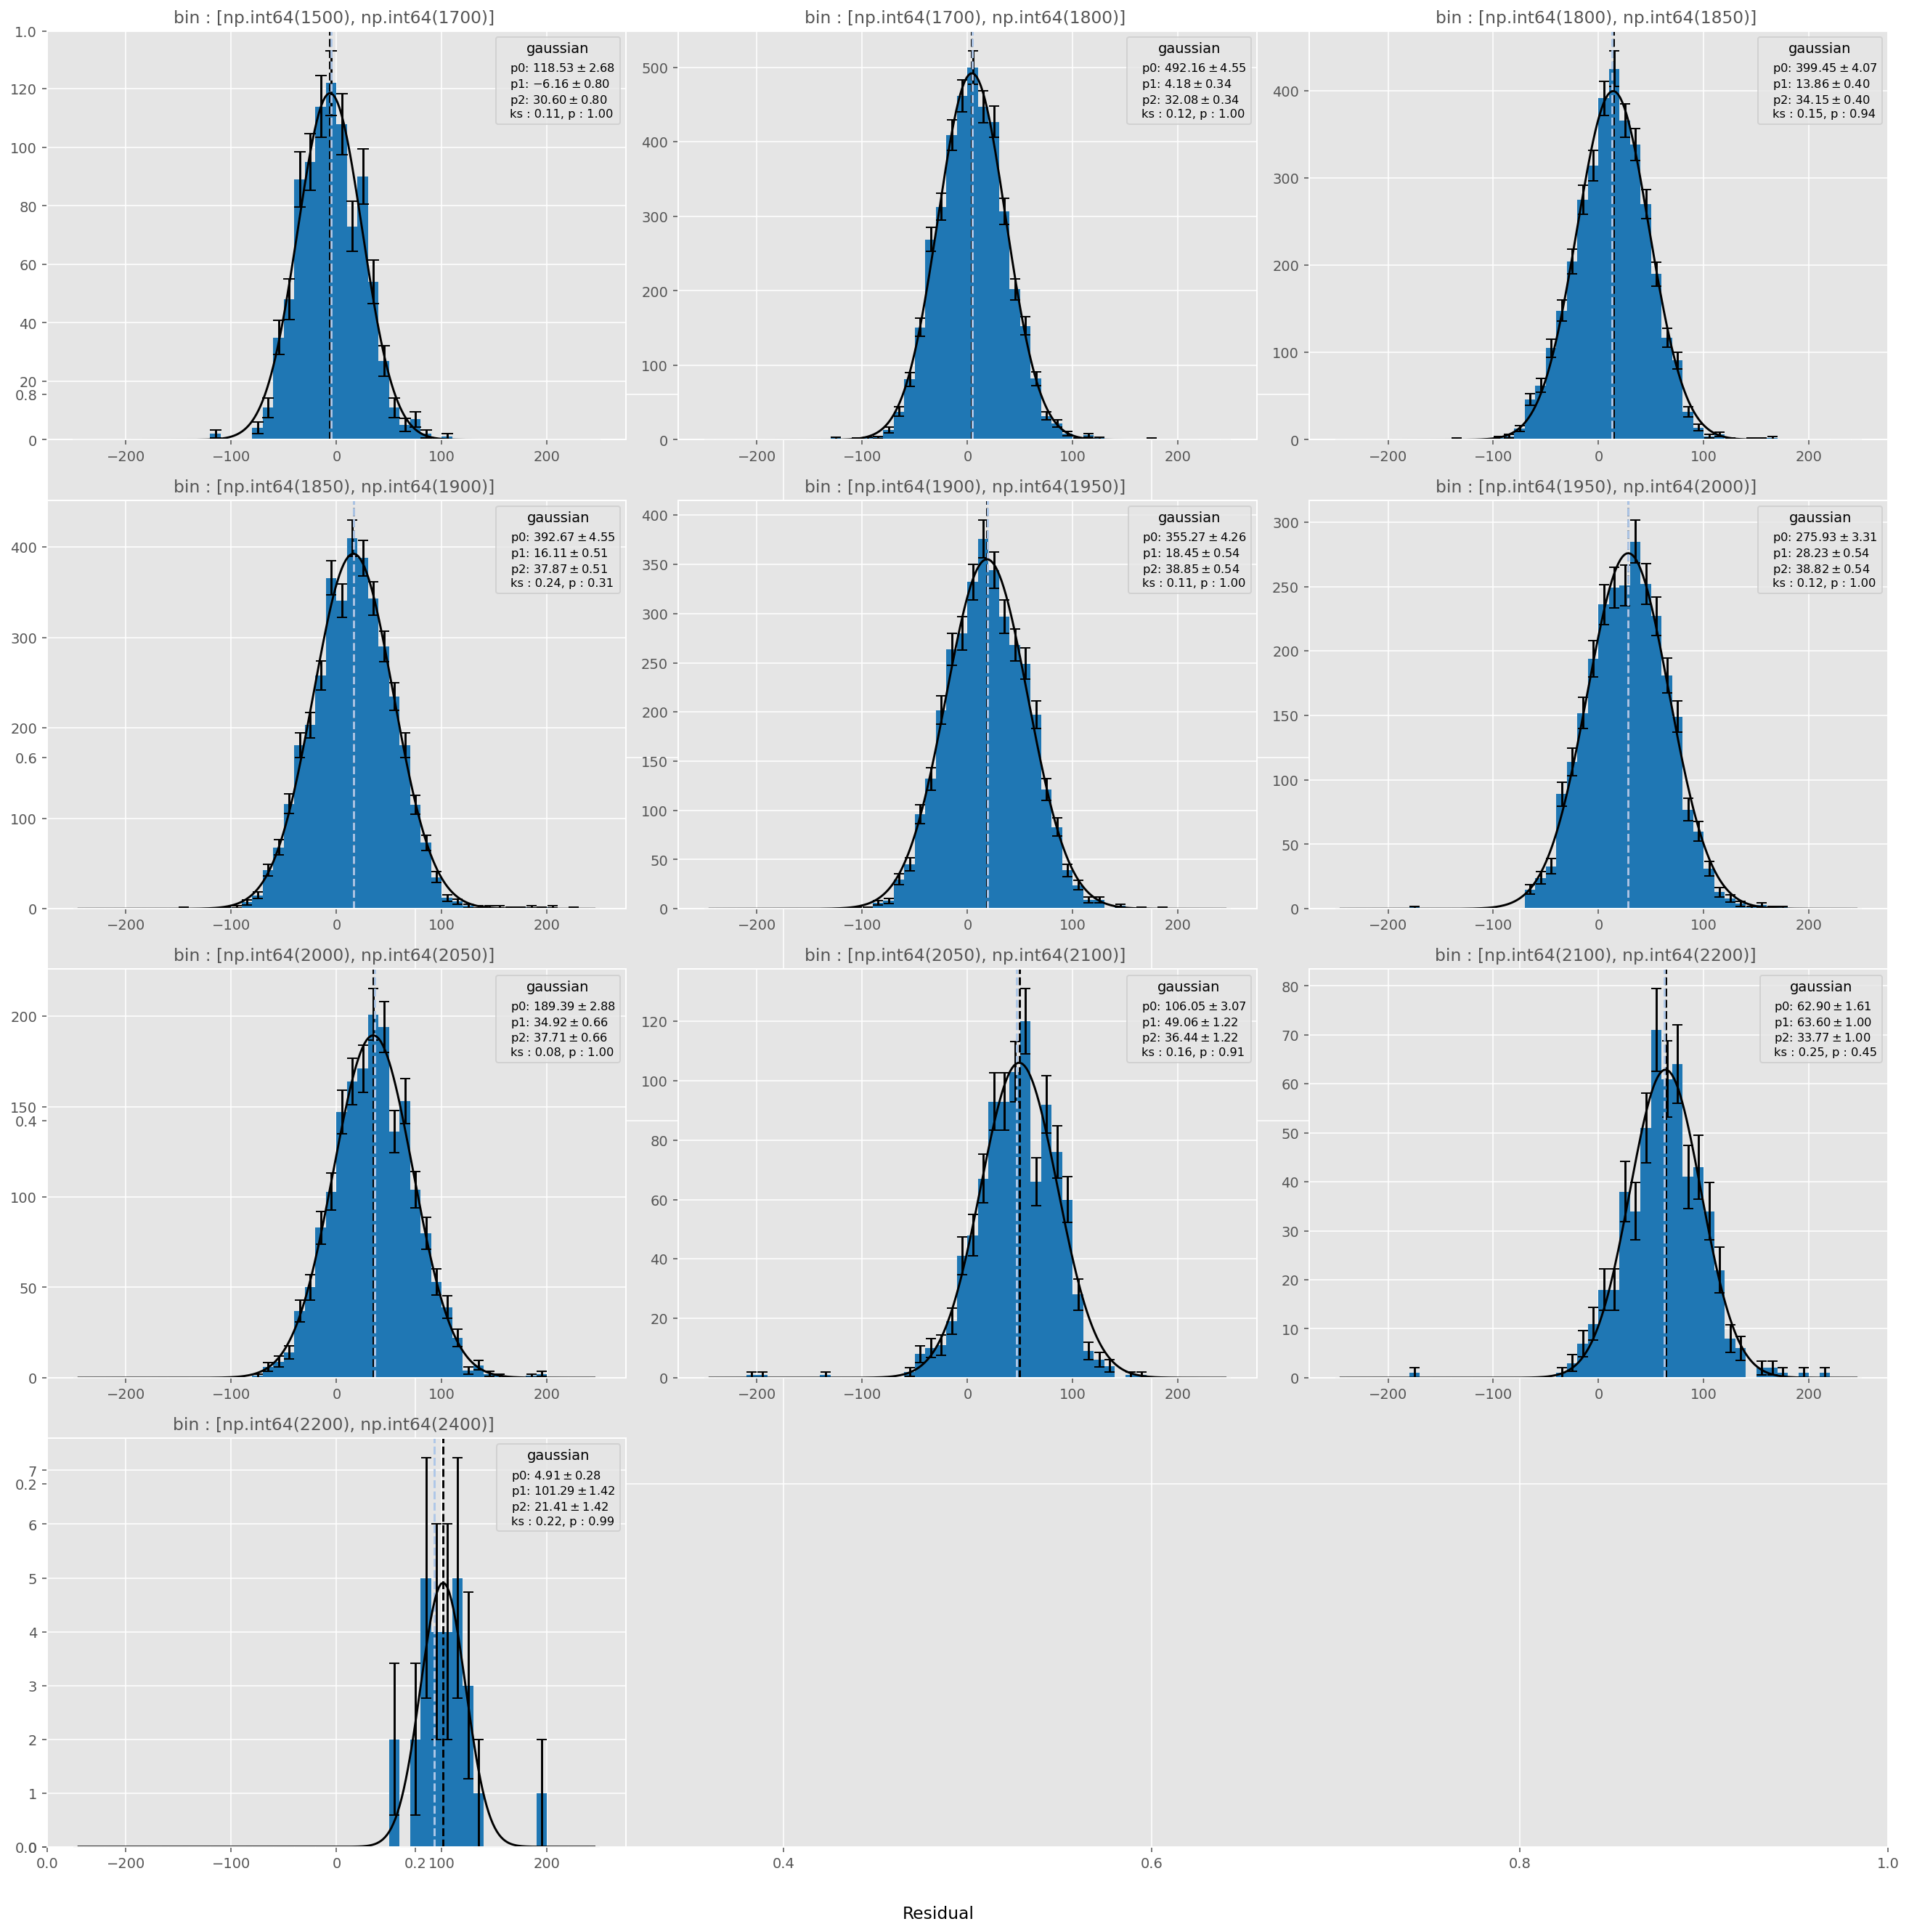

In [12]:
df = pd.DataFrame({"KE_inst" : KE_reco_inst, "true_ffKE" : KE_true_ff})
df["residual"] = df.KE_inst - df.true_ffKE
print(df)

functions = {
    "crystal_ball" : Fitting.crystal_ball,
    "double_gaussian" : Fitting.double_gaussian,
    "student_t" : Fitting.student_t,
    "gaussian" : Fitting.gaussian
}

for f in functions:
    cv = Fitting.ExtractCentralValues_df(df, "KE_inst", "residual", [-250, 250], [functions[f]], bins, 50, rms_err = False)
    central_values[f] = {"value" : cv[0], "error" : cv[1]}
    pdf.Save()


[[ 5.87801707e+02 -6.18094274e-01  1.61630754e-04]
 [-6.18094274e-01  6.51794307e-04 -1.70936345e-07]
 [ 1.61630754e-04 -1.70936345e-07  4.49629036e-11]]
[[ 6.10236683e+03 -6.44113948e+00  1.69663947e-03]
 [-6.44113948e+00  6.81622555e-03 -1.79984637e-06]
 [ 1.69663947e-03 -1.79984637e-06  4.76367585e-10]]
[[ 6.55228505e+02 -6.85132759e-01  1.78056201e-04]
 [-6.85132759e-01  7.18530458e-04 -1.87300777e-07]
 [ 1.78056201e-04 -1.87300777e-07  4.89769676e-11]]
[[ 5.47022894e+02 -5.74432268e-01  1.49991089e-04]
 [-5.74432268e-01  6.04937514e-04 -1.58416194e-07]
 [ 1.49991089e-04 -1.58416194e-07  4.16097106e-11]]


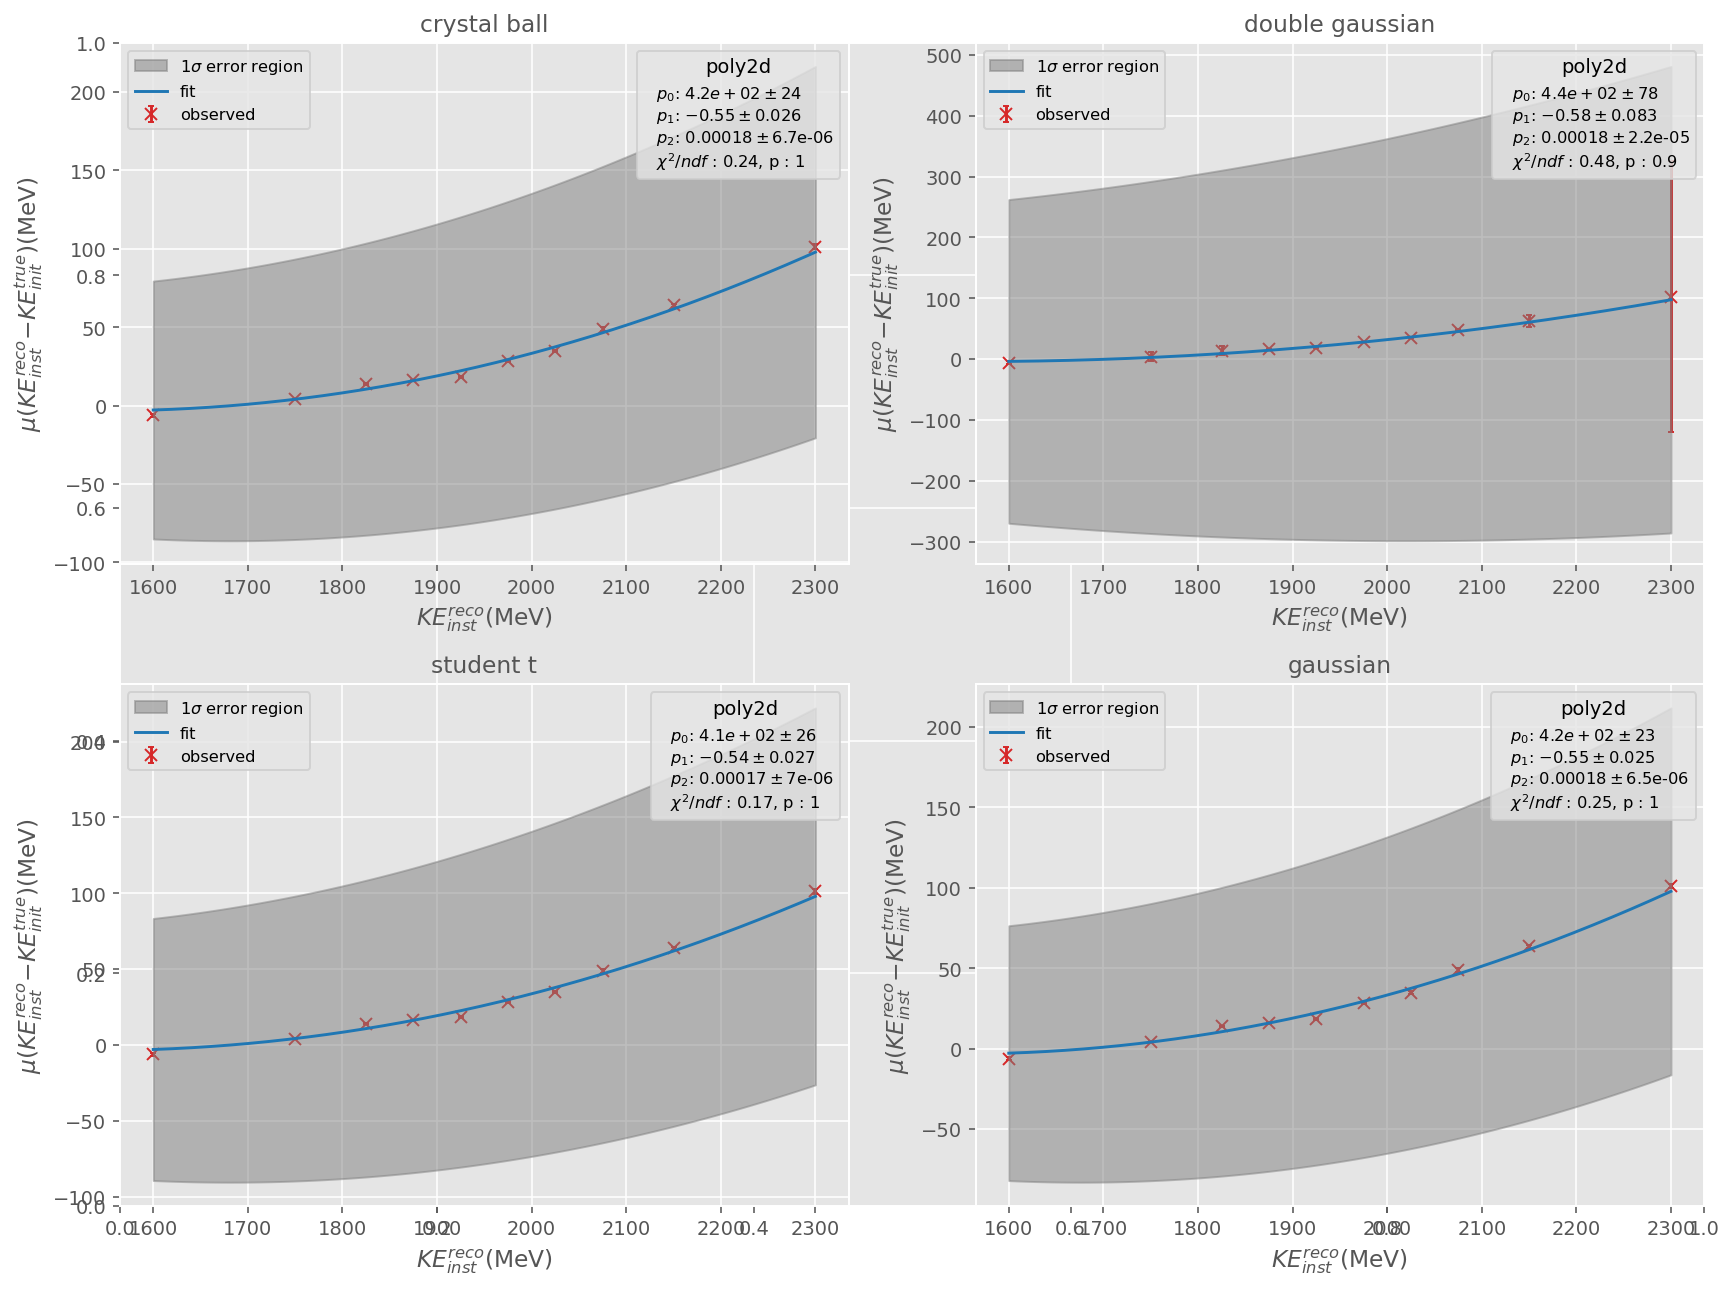

In [13]:
x = (bins[1:] + bins[:-1]) / 2
xerr = abs(x - bins[1:])

popt = {}
perr = {}
if "arithmetic_mean" in central_values:
    central_values.pop("arithmetic_mean")

for i, cv in Plots.IterMultiPlot(central_values):
    params = Fitting.Fit(x, central_values[cv]["value"], central_values[cv]["error"], Fitting.poly2d, plot = True, xlabel = labels.KE_reco_inst + labels.MeV, ylabel = labels.mu_KE_reco_inst_minus_KE_true_ff + labels.MeV, maxfev = int(5E5))
    plt.title(cv.replace("_", " "))
    fmt = lambda x : {f"p{i}" : x[i] for i in range(len(x))}
    popt[cv] = fmt(params[0])
    perr[cv] = fmt(params[1])
pdf.Save()


#### Compare to other analyses (You need to run with the 1GeV sample)

['p0 : 2.2e+02 \\pm 12', 'p1 : -0.62 \\pm 0.028', 'p2 : 0.00043 \\pm 1.6e-05']

['p0 : 2.2e+02 \\pm 43', 'p1 : -0.63 \\pm 0.1', 'p2 : 0.00045 \\pm 6.3e-05']

['p0 : 1.7e+02 \\pm 13', 'p1 : -0.57 \\pm 0.03', 'p2 : 0.00043 \\pm 1.7e-05']

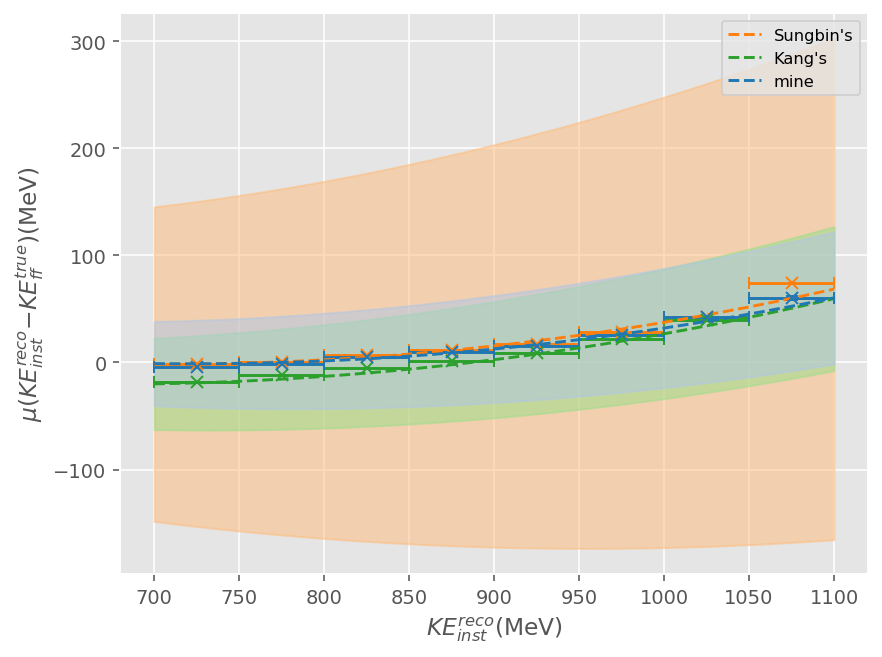

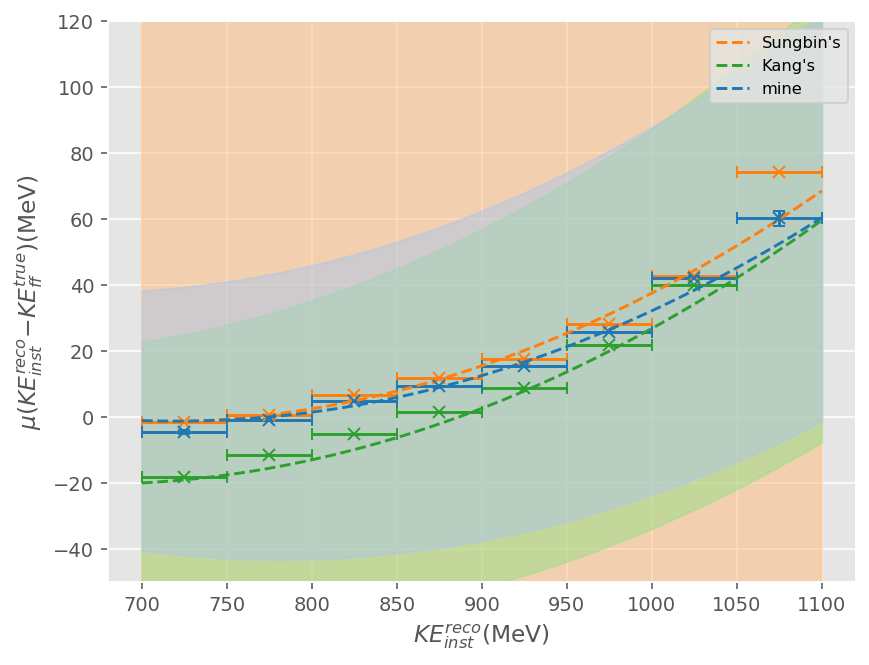

In [99]:
x_interp = np.linspace(700, 1100, 1000)

# Sungbin's correction parameters
s_popt = np.array([2.223e+02, -6.348e-01, 4.500e-04])
s_err = np.array([4.31e+01, 1.04e-01, 6.33e-05])

s_x = [725, 775, 825, 875, 925, 975, 1025, 1075]
s_y = [-1.5209125475285177, 0.5323193916349815, 6.692015209125476, 11.711026615969583, 17.642585551330797, 28.136882129277566, 42.737642585551335, 74.22053231939164]

# Kangs's correction parameters
k_popt = np.array([171.8, -0.575, 4.3e-4])
k_err = np.array([13.1, 0.03, 1.75e-5])

k_x = [725, 775, 825, 875, 925, 975, 1025]
k_y = [-18.21656050955414, -11.59235668789809, -5.222929936305732, 1.4012738853503173, 8.789808917197451, 21.783439490445858, 39.87261146496815]

for v, e in zip([popt["gaussian"], s_popt, k_popt], [perr["gaussian"], s_err, k_err]):
    print([f"p{i} : {v[i]:.2g} \pm {e[i]:.2g}" for i in range(len(v))])

def upstream_loss_fit():
    plt.figure()
    Plots.Plot(s_x, s_y, xerr = 25, marker = "x", linestyle = "", color = "C2", newFigure = False)
    Plots.Plot(x_interp, Fitting.poly2d.func(x_interp, *s_popt), newFigure = False, color = "C2", linestyle = "--", label = f"Sungbin's")
    plt.fill_between(x_interp, Fitting.poly2d.func(x_interp, *(s_popt - s_err)), Fitting.poly2d.func(x_interp, *(s_popt + s_err)), alpha = 0.5, color = "C3")

    Plots.Plot(k_x, k_y, xerr = 25, marker = "x", linestyle = "", color = "C4", newFigure = False)
    Plots.Plot(x_interp, Fitting.poly2d.func(x_interp, *k_popt), newFigure = False, color = "C4", linestyle = "--", label = f"Kang's")
    plt.fill_between(x_interp, Fitting.poly2d.func(x_interp, *(k_popt - k_err)), Fitting.poly2d.func(x_interp, *(k_popt + k_err)), alpha = 0.5, color = "C5")

    Plots.Plot(x, central_values["gaussian"]["value"], yerr = central_values["gaussian"]["error"], xerr = 25, marker = "x", linestyle = "", xlabel = labels.KE_reco_inst + labels.MeV, ylabel = labels.mu_KE_reco_inst_minus_KE_true_ff + labels.MeV, newFigure = False)
    Plots.Plot(x_interp, Fitting.poly2d.func(x_interp, *popt["gaussian"]), newFigure = False, color = "C0", linestyle = "--", label = f'mine')
    plt.fill_between(x_interp, Fitting.poly2d.func(x_interp, *(popt["gaussian"] - perr["gaussian"])), Fitting.poly2d.func(x_interp, *(popt["gaussian"] + perr["gaussian"])), alpha = 0.5, color = "C1")


    plt.legend()
    return

upstream_loss_fit()
pdf.Save()

upstream_loss_fit()
plt.ylim(-50, 120)
pdf.Save()

### Comparison

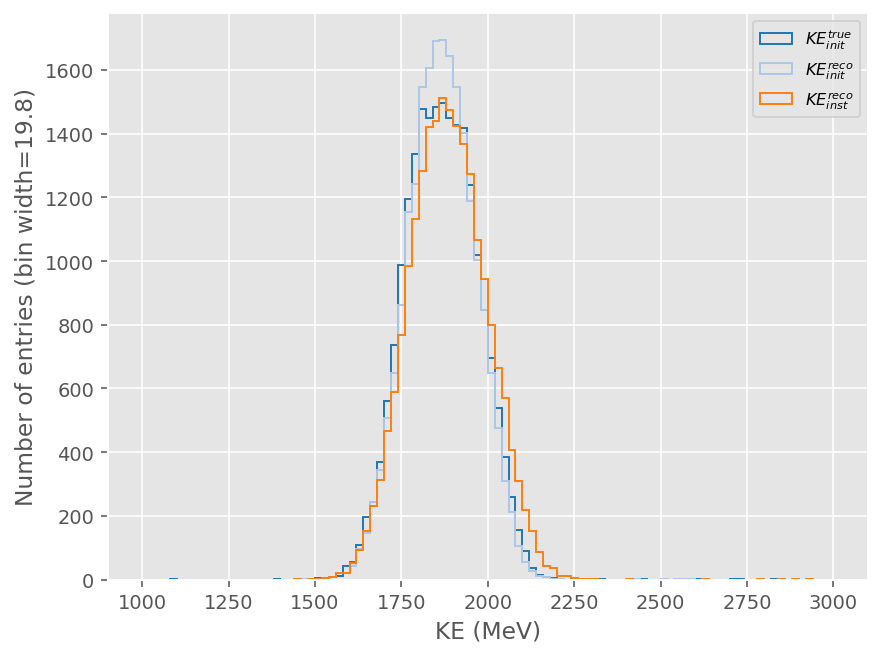

In [14]:
reco_ffKE = KE_reco_inst - cross_section.UpstreamEnergyLoss(KE_reco_inst, popt["gaussian"], Fitting.poly2d)
Plots.PlotHistComparison([KE_true_ff, reco_ffKE, KE_reco_inst], labels = [labels.KE_true_ff, labels.KE_reco_ff, labels.KE_reco_inst], xlabel = "KE " + labels.MeV, x_range = KE_range, density = False)
pdf.Save()


# Energy loss in TPC

In [15]:
dE_true = KE_true_ff - mc.trueParticles.beam_traj_KE[:, -2]
dE_calo = cross_section.RecoDepositedEnergy(mc, reco_ffKE, "calo")
dE_bb = cross_section.RecoDepositedEnergy(mc, reco_ffKE, "bb")

'RecoDepositedEnergy' executed in 12.2779s

'RecoDepositedEnergy' executed in 0.7663s

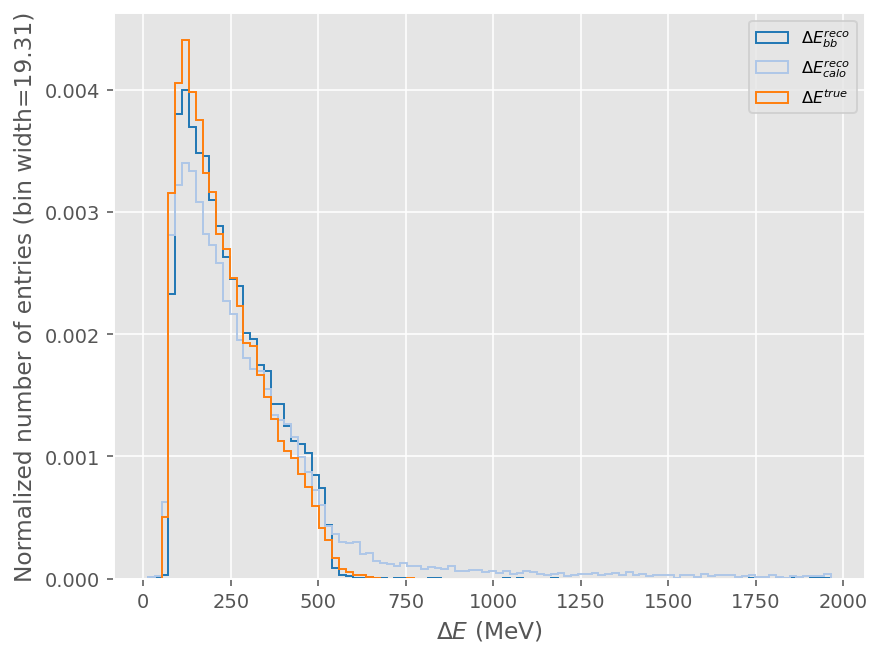

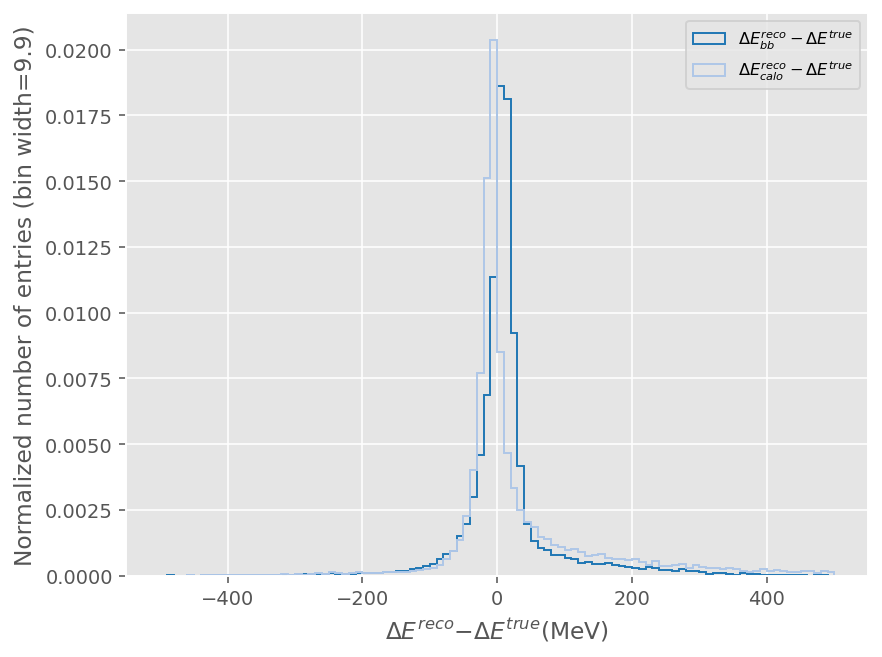

In [17]:
plot_labels = [labels.Delta_E_reco_bb, labels.Delta_E_reco_calo, labels.Delta_E_true]
Plots.PlotHistComparison([dE_bb, dE_calo, dE_true], labels = plot_labels, xlabel = "$\\Delta E$ (MeV)")
pdf.Save()
Plots.PlotHistComparison([dE_bb - dE_true, dE_calo - dE_true], labels = [plot_labels[0][:-1] + "-" + plot_labels[2][1:], plot_labels[1][:-1] + "-" + plot_labels[2][1:]], x_range = [-500, 500], xlabel = labels.Delta_E_reco + "$-$" + labels.Delta_E_true + labels.MeV)
pdf.Save()

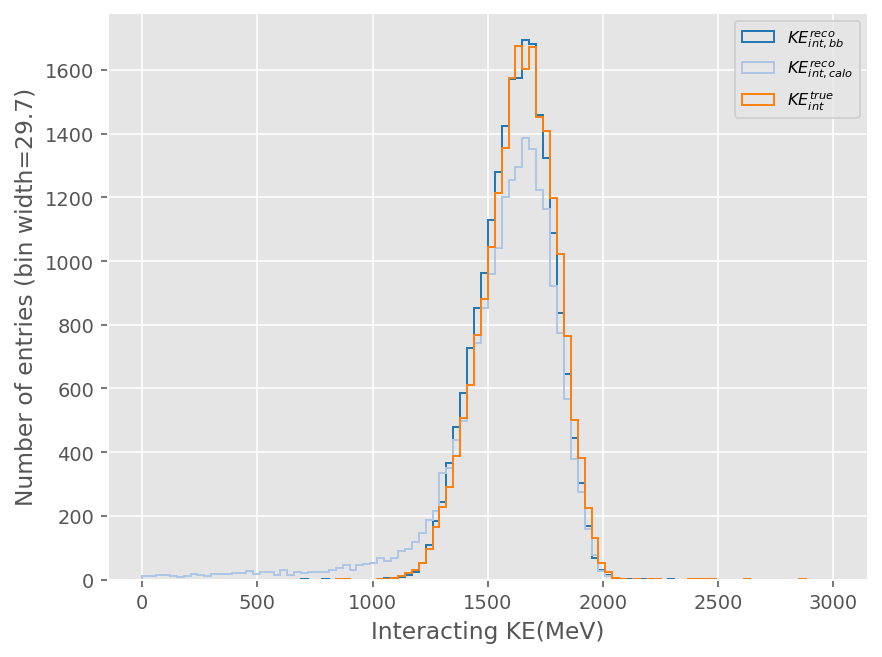

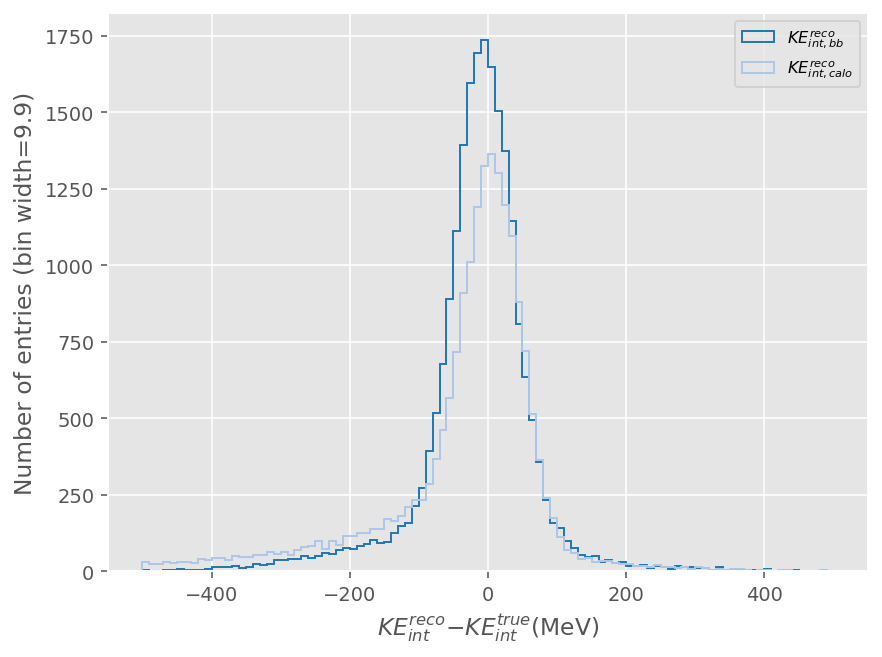

In [16]:
plot_labels = [labels.KE_reco_int_bb, labels.KE_reco_int_calo, labels.KE_true_int]
Plots.PlotHistComparison([reco_ffKE - dE_bb, reco_ffKE - dE_calo, mc.trueParticles.beam_traj_KE[:, -2]], labels = plot_labels, xlabel = "Interacting KE" + labels.MeV, x_range = [0, 3000], density = False)
pdf.Save()
Plots.PlotHistComparison([reco_ffKE - dE_bb - mc.trueParticles.beam_traj_KE[:, -2], reco_ffKE - dE_calo - mc.trueParticles.beam_traj_KE[:, -2]], labels = plot_labels[:-1], x_range = [-500, 500], xlabel = labels.KE_reco_int + "$-$" + labels.KE_true_int + labels.MeV, density = False)
pdf.Save()

In [18]:
pdf.close()

/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis/python/analysis/Plots.py:897: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")
